# SDOBenchmark Dataset

## Data Exploration 

### Dataset in a Nutshell

Lightweight dataset consisting of patches of SDO data consisting of patches centered around the active regions - some of which lead to flares. Prepared by people from FHNW/I4DS.<br>

Algorithm used to create the dataset from the raw data: see https://github.com/i4Ds/SDOBenchmark/blob/master/STRUCTURE.md <br>
- The target active region coordinates identified from TODO, calculated on the current image
- 512 x 512 patch cut out around the rotated coordinates (TODO??)
- Resulting image data clipped by predefined clipping ranges, scaled down to 256x256.
- Result saved to disk as 8-bit JPEG.

Samples consist of 
- 4 time steps with 
- 10 images per time step - 8 images from AIA, 2 images from HMI

### Download Data

Can be downloaded from https://i4ds.github.io/SDOBenchmark/ <br>

Two versions:
- data-full:    ~3730MB on disk (extracted)
- data-example:  ~340MB on disk (extracted)


In [6]:
!mkdir -p ./data
!curl -L https://github.com/i4Ds/SDOBenchmark/archive/data-example.zip > data-example.zip
!unzip -q -o data-example.zip -d ./data
!rm -f data-example.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   128  100   128    0     0     93      0  0:00:01  0:00:01 --:--:--     0--:--:--    93
100  265M  100  265M    0     0  19.0M      0  0:00:13  0:00:13 --:--:-- 27.2M 0:08:47 1364k


Install dependencies

- on Google collab you will need to restart your runtime after this step
- when running this locally, make sure to first follow the setup instructions in the [README](../README.md)

In [2]:
!pip install -U tqdm
!pip install -U torch torchvision
!pip install -U numpy
!pip install -U matplotlib 
!pip install -U Pillow
!pip install -U pandas

In [7]:
# Data location

DATADIR = "./data/SDOBenchmark-data-example"

# download and extract it to DATADIR

# location of data
data_dir_train = "%s/training"%DATADIR
data_dir_test  = "%s/test"%DATADIR

#location of metadata
df_index_train = "%s/training/meta_data.csv"%DATADIR
df_index_test  = "%s/test/meta_data.csv"%DATADIR

### Dataset Structure

- Split into train and test, accordingly you find a $train$- and $test$-folder (8'336 train, 886 test samples).
- Different samples organized in separate subgroups, within a subgroup you will see samples observed close in time (distributed over several days):
    - $\verb|<subgroupid>|$
    - within the subgroup folder the data for __one sample__ can be found in a folder $\verb|<sampleid>|$ named with a date format: $\verb|YYYY-MM-DD-HH-mm-ss-v|$ (v: version ?? TODO)
- Each sample folder contains 40 images - 10 images for each of the 4 time steps.
- Images are named composed of a timestamp followed by the AIA band or HMI specification: $\verb|<timestamp>_<instrument_specifier>.jpg|$
    - timestamp: $\verb|YYYY\_MMTDDHHmmss|$
    - instrument specifier: 
        - for AIA: $\verb|94, 131, 171, 193, 211, 304, 335, 1700|$
        - for HMI: $\verb|continuum, magnetogram|$
- Label information provided in form of peak flux values:
    - one line per sample with $id$ ($\verb|<subgroupid>_<sampleid>|$), time range the images refer to ($start$, $end$) and $\verb|peak_flux|$ for the projection period.
    - the peak flux can be translated to a flare class label by comparing it with a threshold (for flare classes $\ge$ C we would use a threshold 1.0e-6, for flare classes $\ge$ M a threshold 1.0e-5). 

_Remark_: When splitting train into train and validate it is recommended to split along the subgroups, i.e. not split up the subgroups. 

The thresholding drives the distribution of the flare classes. When referring to FLARE as at least class C flare, we obtain 
- train: 346 flare and 7051 non-flare samples (TODO: these numbers are inconsistent) 
- test:  157 flare and  673 non-flare samples


#### Missing Data

Not for all samples we have data for all the 10 channels. This should be considered when loading and possibly processing and modeling the data.


### Data Access

In [8]:
import os
from datetime import datetime, timedelta
from dateutil import parser
import random
import pandas as pd
from PIL import Image

AIA_94, AIA_131, AIA_171, AIA_193, AIA_211, AIA_304, AIA_335, AIA_1700 = "94", "131", "171", "193", "211", "304", "335", "1700"
HMI_CONT, HMI_MAGN = "continuum", "magnetogram"
ALL_CHANNELS = [AIA_94, AIA_131, AIA_171, AIA_193, AIA_211, AIA_304, AIA_335, AIA_1700, HMI_CONT, HMI_MAGN]

TIMESTEPS = [timedelta(), timedelta(hours=7), timedelta(hours=10, minutes=30), timedelta(hours=11, minutes=50)]

DATEFORMAT_IMGNAME = "%Y-%m-%dT%H%M%S"

class SDOBenchmarkIndex():
    
    def __init__(self, data_dir, df_index, channels=None, threshold=10e-6):
        self.data_dir = data_dir
        self.df_index = pd.read_csv(df_index)
        self.channels = self.channels_to_check(channels)
        self.threshold = threshold
        self.sample_dirs = []
        self.image_files = {}
        self.labels = {}

        print("Checking for channels: %s"%', '.join([ch for ch in self.channels]))
        print("Using threshold      : %9.8f"%self.threshold)
        
        for index, row in self.df_index.iterrows():
            groupid = row['id'][:5]
            dateid = row['id'][6:]
            group_dir = os.path.join(data_dir,groupid )
            sample_dir = os.path.join(group_dir, dateid)
            start_date = parser.parse(row['start'])

            if self.check_sample_dir(sample_dir, start_date, self.channels):
                imgs_steps = {}
                self.sample_dirs.append(sample_dir)
                self.labels[sample_dir] = self.create_binary_label(row['peak_flux'])
                for i in range(len(TIMESTEPS)):
                    imgs_channels = {}
                    for ch in self.channels:
                        _name = self.create_image_name(start_date, TIMESTEPS[i], ch) 
                        imgs_channels[ch] = os.path.join(sample_dir, _name)
                    imgs_steps[i] = imgs_channels
            
                self.image_files[sample_dir]=imgs_steps

        print("Found %i samples from which %i are flares."%(len(self.sample_dirs), sum(self.labels.values())))

    def channels_to_check(self, channels):
        if not channels:
            channels = ALL_CHANNELS.copy()
        return channels

    def create_image_name(self, base_date, delta, channel):
        img_date = base_date+delta
        img_name = "%s__%s.jpg"%(datetime.strftime(img_date, DATEFORMAT_IMGNAME),channel)
        return img_name
    
    def check_sample_dir(self, sample_dir, start, channels): #check if the directory contains all samples (no missing)        
        for delta in TIMESTEPS:
            for ch in channels:
                _name = self.create_image_name(start, delta, ch)
                _path = os.path.join(sample_dir, _name)
                if not os.path.exists(_path):
                    return False
        return True

    def create_binary_label(self, val):
        return int(val>self.threshold)


In [9]:
train_index = SDOBenchmarkIndex(data_dir_train, df_index_train, channels=(HMI_MAGN,))

Checking for channels: magnetogram
Using threshold      : 0.00001000
Found 376 samples from which 21 are flares.


### Some Glances at the Data

In [10]:
import matplotlib.pyplot as plt
import numpy as np

In [11]:
data = train_index

#### Load Data

In [12]:
from PIL import Image

(256, 256) L
0 255


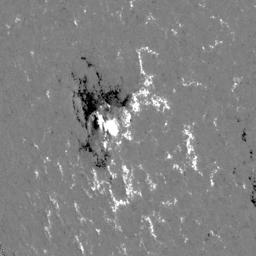

In [13]:
sample = np.random.choice(list(data.image_files.keys()))
channel = HMI_MAGN
timestep = 0

image_path = data.image_files[sample][timestep][channel]
image = Image.open(image_path)
imgarray = np.asarray(image)

print(image.size, image.mode)
print(imgarray.min(), imgarray.max())
image

#### Plot Timesteps

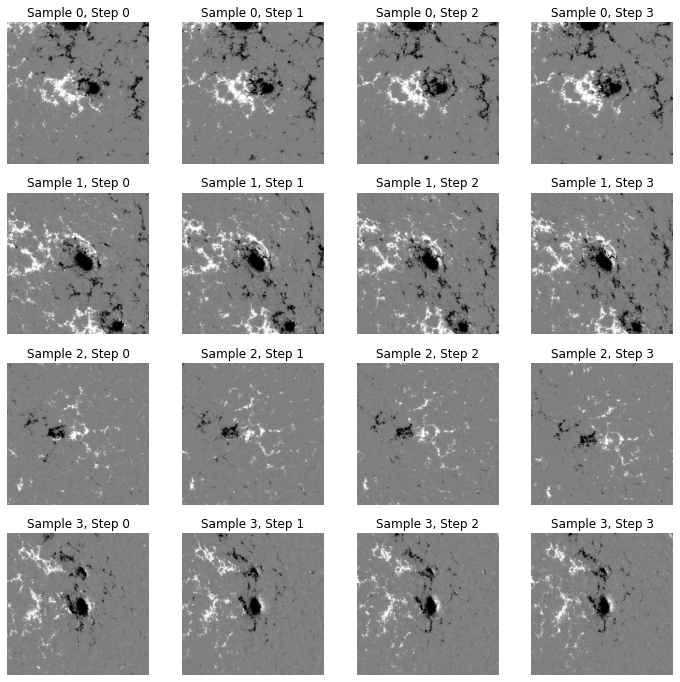

In [14]:
nsamples = 4
channel = HMI_MAGN

samples = [np.random.choice(list(data.image_files.keys())) for i in range(nsamples)]
nsteps = 4

plt.figure( figsize=(nsteps*3,nsamples*3) )
for i in range(nsamples):
    for j in range(nsteps):
        plt.subplot( nsamples, nsteps, nsamples*i+j+1 )
        image_file = data.image_files[samples[i]][j][channel]
        image = plt.imread(image_file)
        plt.title( "Sample %i, Step %i"%(i,j))
        plt.imshow( image[:,:], cmap="gray" )
        plt.axis('off')

#### Plot Large Mosaic (Timestep 0)

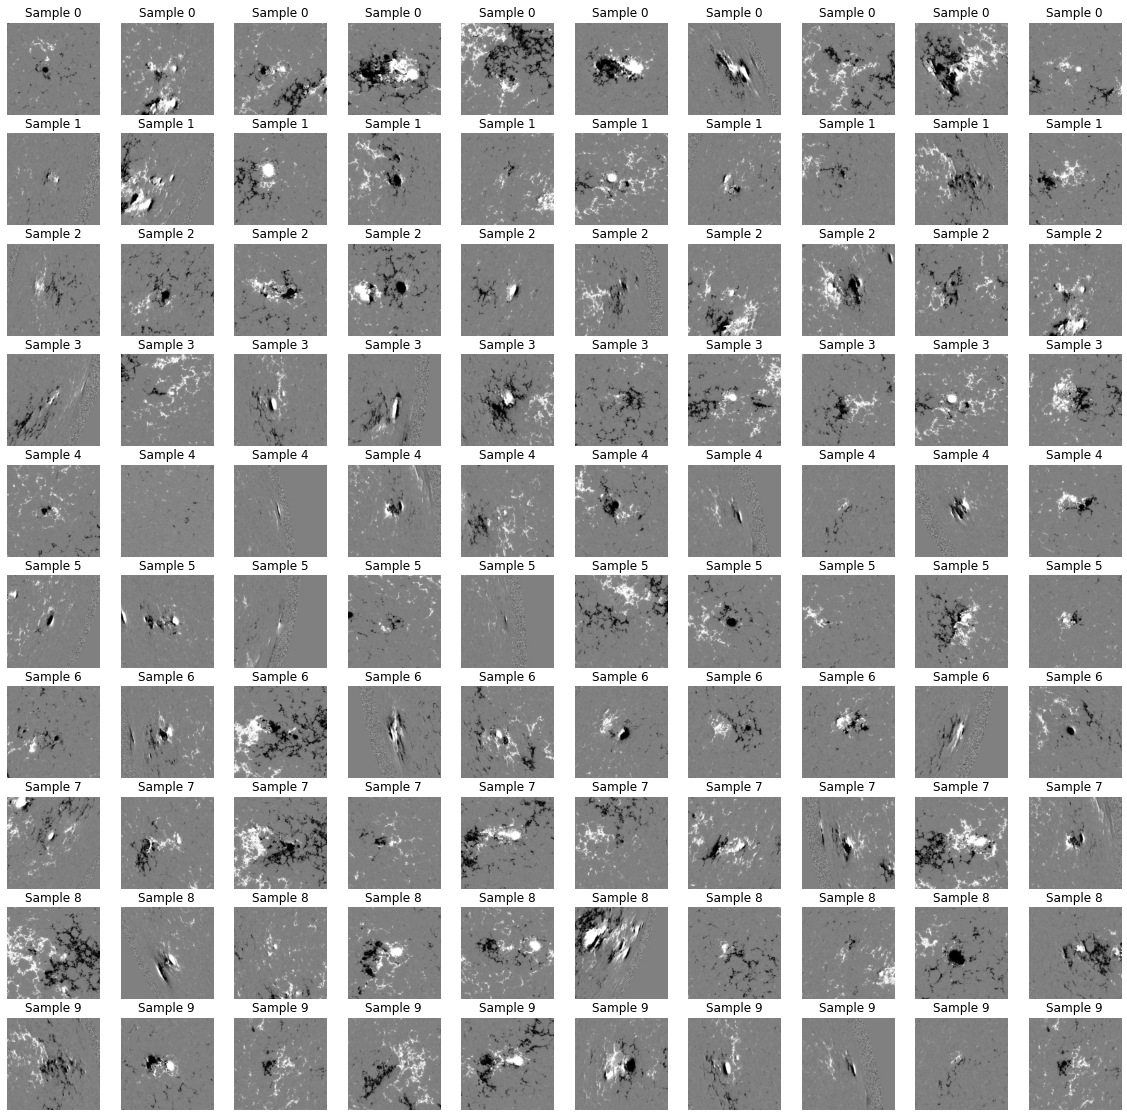

In [15]:
n = 10
channel = HMI_MAGN
timestep = 0

plt.figure( figsize=(n*2,n*2) )
samples = [np.random.choice(list(data.image_files.keys())) for i in range(n*n)]

for i in range(n):
    for j in range(n):
        plt.subplot( n, n, n*i+j+1 )
        image_file = data.image_files[samples[n*i+j]][timestep][channel]
        image = plt.imread(image_file)
        plt.title( "Sample %i"%(i))
        plt.imshow( image[:,:], cmap="gray" )
        plt.axis('off')

#### Flux Distribution

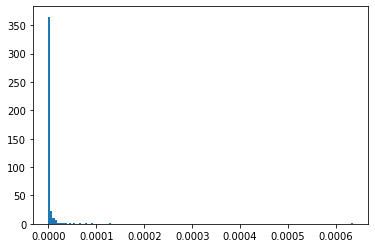

In [16]:
hist, bins, _ = plt.hist(data.df_index.peak_flux, bins=150)

## Modeling the Data

### PyTorch Data Loader (Dataset)

using SDOBenchmarkIndex 

without data augmentation (??)

In [17]:
import torch

from torch.utils.data import Dataset

In [18]:
# TODO


class SDOBenchmarkDataset(Dataset): 
    
    def __init__(self, index):
        # TODO
        pass
    

# CNN

TODO